# KBS Assignment 1  
## Nairobi Securities Exchange Stock Price Prediction (2007–2012)

### Objective
To build and evaluate regression models that predict numerical stock values
using historical data from the Nairobi Securities Exchange (NSE).

### Dataset
- Source: NSE All Stocks Prices (2007–2012)
- Format: Daily trading records per stock

### Task
- Select one or more stocks
- Engineer features from historical prices
- Train regression models
- Evaluate performance using MSE, RMSE, R²
- Produce residual and error plots


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Data Loading Function

In [12]:
def load_nse_data():
    """Load and combine all NSE CSV files"""
    
    data_folder = "../data/"
    years = list(range(2007, 2013))
    data_frames = []
    
    for year in years:
        file_path = os.path.join(data_folder, f"NSE_data_all_stocks_{year}.csv")
        if os.path.exists(file_path):
            df_year = pd.read_csv(file_path)
            df_year['Year'] = year
            data_frames.append(df_year)
            print(f"✓ {year}: {len(df_year)} records")
    
    nse_data = pd.concat(data_frames, ignore_index=True)
    print(f"\nCombined dataset shape: {nse_data.shape}")
    
    return nse_data


Inspecting the datasets

In [13]:
nse_data = load_nse_data()

print("Columns:")
print(nse_data.columns)

print("\nMost common stocks:")
print(nse_data['CODE'].value_counts().head(10))

✓ 2007: 10608 records
✓ 2008: 10583 records
✓ 2009: 14386 records
✓ 2010: 14952 records
✓ 2011: 14931 records
✓ 2012: 16044 records

Combined dataset shape: (81504, 16)
Columns:
Index(['DATE', 'CODE', 'NAME', '12m Low', '12m High', 'Day Low', 'Day High',
       'Day Price', 'Previous', 'Change', 'Change%', 'Volume', 'Adjust',
       'Year', 'Date', 'Adjusted'],
      dtype='object')

Most common stocks:
CODE
HFCK    1501
KCB     1501
KEGN    1501
EVRD    1501
MSC     1501
NIC     1500
SCAN    1500
BBK     1500
CMC     1500
SASN    1500
Name: count, dtype: int64


In [14]:
def clean_numeric_column(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str).str.replace(',', '')
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df

In [15]:
stock_code = "SCOM"
stock_data = nse_data[nse_data['CODE'] == stock_code].copy()

stock_data['DATE'] = pd.to_datetime(stock_data['DATE'])
stock_data = stock_data.sort_values('DATE')

print(f"Trading days: {len(stock_data)}")
print(f"Date range: {stock_data['DATE'].min().date()} to {stock_data['DATE'].max().date()}")

stock_data['Day Price'].describe()

Trading days: 1146
Date range: 2009-01-02 to 2012-12-31


count     1146
unique      91
top        3.9
freq        46
Name: Day Price, dtype: object

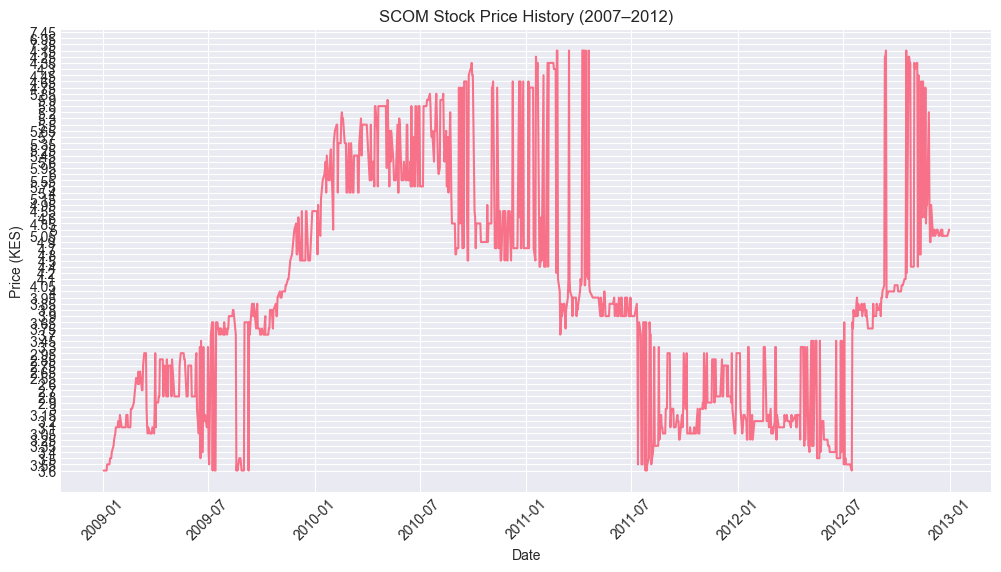

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data['DATE'], stock_data['Day Price'])
plt.xlabel('Date')
plt.ylabel('Price (KES)')
plt.title(f'{stock_code} Stock Price History (2007–2012)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [18]:
stock_data = clean_numeric_column(stock_data, 'Volume')

stock_data['Change'] = stock_data['Change'].replace('-', '0')
stock_data['Change'] = pd.to_numeric(stock_data['Change'], errors='coerce')

stock_data['Change%'] = stock_data['Change%'].replace('-', '0%')
stock_data['Change%'] = stock_data['Change%'].str.replace('%', '')
stock_data['Change%'] = pd.to_numeric(stock_data['Change%'], errors='coerce')

target_col = 'Day Price'

In [ ]:
# ---------------------------------------------
# STEP: Clean and convert numeric columns from string
# ---------------------------------------------

numeric_cols = [
    'Day Price',
    'Day High',
    'Day Low',
    'Previous',
    'Volume',
    'Change',
    'Change%'
]

for col in numeric_cols:
    if col in stock_data.columns:
        stock_data[col] = (
            stock_data[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.replace('%', '', regex=False)
            .replace('-', np.nan)
        )
        stock_data[col] = pd.to_numeric(stock_data[col], errors='coerce')

# Confirm conversion
stock_data[numeric_cols].dtypes


Day Price    float64
Day High     float64
Day Low      float64
Previous     float64
Volume         int64
Change       float64
Change%      float64
dtype: object

In [22]:
num_lags = 5

for lag in range(1, num_lags + 1):
    stock_data[f'Price_lag_{lag}'] = stock_data[target_col].shift(lag)

stock_data['Price_MA_5'] = stock_data[target_col].rolling(5).mean().shift(1)
stock_data['Price_MA_10'] = stock_data[target_col].rolling(10).mean().shift(1)
stock_data['Price_MA_20'] = stock_data[target_col].rolling(20).mean().shift(1)

stock_data['Daily_Range'] = (stock_data['Day High'] - stock_data['Day Low']) / stock_data[target_col]
stock_data['Daily_Range_lag1'] = stock_data['Daily_Range'].shift(1)

stock_data['Volume_lag1'] = stock_data['Volume'].shift(1)
stock_data['Volume_MA_5'] = stock_data['Volume'].rolling(5).mean().shift(1)

stock_data['Change_lag1'] = stock_data['Change'].shift(1)
stock_data['Change%_lag1'] = stock_data['Change%'].shift(1)
stock_data['Previous_lag1'] = stock_data['Previous'].shift(1)


In [23]:
stock_data_clean = stock_data.dropna()

feature_cols = [f'Price_lag_{i}' for i in range(1, 6)] + [
    'Price_MA_5', 'Price_MA_10', 'Price_MA_20',
    'Daily_Range_lag1', 'Volume_lag1', 'Volume_MA_5',
    'Change_lag1', 'Change%_lag1', 'Previous_lag1'
]

X = stock_data_clean[feature_cols]
y = stock_data_clean[target_col]

print(X.shape, y.shape)

(0, 14) (0,)


In [24]:
split_index = int(0.8 * len(X))

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]